In [8]:
# import required packages
import pandas as pd
import numpy as np
import math

# advanced statistics library
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.patches as mp
import matplotlib.colors as colors

# SEE COMMENTS ABOUT PYSHEDS LIBRARY IN NEXT CELL
from pysheds.grid import Grid
import warnings
warnings.filterwarnings('ignore')

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import LinearColorMapper, LogTicker, ColorBar, BasicTickFormatter
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [9]:
#longitude changes
#earth's radius = 6371 m
# x = R*cosL, R = earth radius, L = degree of latitude (in degrees) (x = radius of circle at that lat)
#circ = x*2*pi
# dist bw 2 lines of longitude = circ/360

def longdist(L):
    
    R = 6371*1000 #earth's radius in m
    lat = L*(math.pi/180) #changing input lat from degree to radians
    x = R*math.cos(lat) # in m
    circ = x*2*math.pi #in m
    
    longdist.dist_long = circ/360
    
    #print(longdist.dist_long)

In [10]:
def accumulation(x,y,scope):
    
    print('')
    print('\033[1m'+'First, finding the point of maximum accumulation near the inputted coordinates:'+'\033[0m')
    print('')
    
    # x = known x coordinate/longitude
    # y = known y coordinate/latitude
    # scope = how many cells around the coordinate that the function searches

    grid = Grid.from_ascii(path='../../data/notebook_5_data/n49w1235_con_grid.asc', 
                       data_name='dem')

    grid.nodata = 0

    map_extents = grid.extent
    min_x, max_x, min_y, max_y = map_extents

    grid.resolve_flats('dem', out_name='inflated_dem')

    #         N    NE    E    SE    S    SW    W    NW
    dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

    grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)

    y,x = 49.45884351833498 , -123.23060902788554

    grid.accumulation(data='dir', dirmap=dirmap, out_name='acc2')

    #uncomment next few lines to see the map of accumulation in the whole dem area
    #fig = plt.figure(figsize=(8,6))
    #fig.patch.set_alpha(0)

    #plt.imshow(grid.acc2, extent=grid.extent, zorder=2, cmap='cubehelix',
               #norm=colors.LogNorm(1, grid.acc2.max()*0.1))

    #plt.xlabel('Longitude')
    #plt.ylabel('Latitude')
    #plt.title('Flow accumulation grid')
    #plt.grid(zorder=-1)
    #plt.tight_layout()
        
    grid.accumulation(data='dir', dirmap=dirmap, out_name='acc2')

    cellrow = 900-(y-min_y)/(max_y-min_y)*900 #cell row = row number of inputted coordinate
    cellcol = (x-min_x)/(max_x-min_x)*1200

    rownumber = int(cellrow)
    colnumber = int(cellcol)

    searchgrid2 = grid.acc2[rownumber-scope:rownumber+scope+1,colnumber-scope:colnumber+scope+1]

    max_acc = searchgrid2.max()

    print("The maximum accumulation is:",max_acc)

    #print(grid.acc2[rownumber,colnumber]) #showing the value in the original grid

    #print(searchgrid2.shape) #showing the shape of the search grid, should be 2*scope +1

    for i in range(len(searchgrid2)): #look in rows
        for j in range(len(searchgrid2[0])): #look in columns
            if searchgrid2[i,j]==max_acc:
                #The row number of max acc point in the search grid is: i
                #The column number of max acc point in the search grid is: j
                #Remember that numbering starts from 0.
                newrow = i
                newcol = j

    newrowglobal = rownumber - scope + newrow 
    newcolglobal = colnumber - scope + newcol
            
    accumulation.newy = (((900-newrowglobal)/900)*(max_y-min_y)) + min_y
    accumulation.newx = (((newcolglobal+1)/1200)*(max_x-min_x)) + min_x #unsure about why +1 is needed, but it yields the same point as input when scope = 0

    print("The coordinates of the max acc point are (y,x) or (lat,long):",accumulation.newy,",",accumulation.newx)
    

In [11]:
def catchmentcharacteristics(x,y):
    
    print('')
    print('\033[1m'+'Then, finding catchment characteristics:'+'\033[0m')
    print('')
    
    grid = Grid.from_ascii(path='../../data/notebook_5_data/n49w1235_con_grid.asc', 
                       data_name='dem')
    
    grid.nodata = 0
    
    map_extents = grid.extent
    min_x, max_x, min_y, max_y = map_extents
    
    tools = "pan,wheel_zoom,box_zoom,reset,tap"

    # show the precision of the decimal coordinates
    # in the plot to 5 decimal places
    TOOLTIPS = [
        ("(x,y)", "($x{1.11111}, $y{1.11111})"),]

    # create a figure, setting the x and y ranges to the appropriate data bounds
    p1 = figure(title="DEM of the Lower Mainland of BC.  Hover to get coordintes.", plot_width=600, plot_height=int(400),
                x_range = map_extents[:2], y_range = map_extents[2:], 
                tools=tools, tooltips=TOOLTIPS)

    # map elevation to a colour spectrum
    color_mapper = LinearColorMapper(palette="Magma256", low=-200, high=2400)

    # np.flipud flips the image data on a vertical axis
    adjusted_img = [np.flipud(grid.dem)]  

    p1.image(image=adjusted_img,   
             x=[min_x],               # lower left x coord
             y=[min_y],               # lower left y coord
             dw=[max_x-min_x],        # *data space* width of image
             dh=[max_y-min_y],        # *data space* height of image
             color_mapper=color_mapper)

    color_bar = ColorBar(color_mapper=color_mapper, #ticker=Ticker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

    p1.add_layout(color_bar, 'right')

    grid.resolve_flats('dem', out_name='inflated_dem')
    
    dirmap = (64,  128,  1,   2,    4,   8,    16,  32)
    
    grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)
    
    grid.clip_to('dem')
    grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
                   recursionlimit=15000, xytype='label', nodata_out=0)
    
    grid.clip_to('catch', pad=(0,0,0,0))
    
    catch = grid.view('catch', nodata=np.nan)
    
    print('The shape of the catchment is:',catch.shape,'. Use this to check if the input coordinates are correct.')
    
    ext_1 = grid.extent
    
    grid.accumulation(data='catch', dirmap=dirmap, out_name='acc')

    grid.flow_distance(data='catch', x=x, y=y, dirmap=dirmap, out_name='dist', xytype='label', nodata_out=np.nan)
        
    #from cell above:
    #           N    NE    E    SE    S    SW    W    NW
    # dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

    # distance between 2 degreess of latitute = 111218.55 m #doesn't change anywhere in the world
    # distance between 2 degrees of longitude = 72499.36 m #use manual function instead
    
    #notation: grid affine 0 = length of one cell in degrees of long and grid affine 4 = length of one cell of lat 

    len_x = grid._affine[0]*longdist.dist_long #length of one cell of longitude in graph in m (x axis)

    len_y = grid._affine[4]*(-111218.55) #length of one cell of latitude in graph in m (y axis)

    len_diag = (len_x**2 + len_y**2)**0.5

    dir = grid.view('dir', nodata=np.nan)

    weights = (np.where((dir==64), len_y, 0) + np.where((dir==128), len_diag, 0) + 
               np.where((dir==1), len_x, 0) + np.where((dir==2), len_diag, 0) + 
               np.where((dir==4), len_y, 0) + np.where((dir==8), len_diag, 0) + 
               np.where((dir==16), len_x, 0) + np.where((dir==32), len_diag, 0)).ravel()
    
    grid.flow_distance(data='catch', x=x, y=y, weights=weights, dirmap=dirmap, out_name='dist2',
                   xytype='label', nodata_out=np.nan)
    
    grid.clip_to('catch')

    dem_small = grid.view('inflated_dem')

    dem_small[dem_small<0] = np.nan #make any non negative values a nan
    
    dem_small[dem_small>0].min() #finding elevation of intake (min of the catchment)

    height_above_outlet = dem_small - dem_small[dem_small>0].min() #finding elevation difference

    slope = height_above_outlet / grid.dist2 #grid of slope in m/m
    
    print('')
    
    # Plot the catchment
    fig, ax = plt.subplots(figsize=(10,9))
    fig.patch.set_alpha(0)

    plt.grid('on', zorder=0)

    im = ax.imshow(catch, extent=grid.extent, zorder=1, cmap='viridis')
    plt.colorbar(im, ax=ax, values=sorted(dirmap), label='Flow Direction')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Delineated Catchment')
    
    fig, ax = plt.subplots(figsize=(10,9))
    fig.patch.set_alpha(0)
    plt.grid('on', zorder=0)
    im = ax.imshow(slope, extent=grid.extent, zorder=2,
                   cmap='cubehelix_r')
    plt.colorbar(im, ax=ax, label='slope (m/m)')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Slope')
    
    print('Average slope of catchment is:',np.nanmean(slope)*1000,'m/km')
    print('The mean elevation of the catchment is:',np.nanmean(dem_small),'m')
    print('The steepest slope in the catchment is:',np.nanmax(slope)*1000,'m/km')
    print('The longest flow distance in the catchment is:',np.nanmax(grid.dist2),'m')
    
    print('')

    print('The following maps show the catchment, and the slope variation in the catchment:')


In [12]:
def main():
    catchment = str(input('What is the name of the catchment? '))
    L = int(input('Please input degree of latitude (nearest integer): '))
    longdist(L)
    x = float(input('Please input the x, or longitude coordinate: '))
    y = float(input('Please input the y, or latitude coordinate: '))
    scope = int(input('Please input the search scope: '))
    
    print('')
    print('\033[1m'+catchment+' Characteristics'+'\033[0m')
    
    accumulation(x,y,scope)
    
    answer = str(input('Do you want to use the new coordinates to define the catchment(Y/N or yes/no)? '))
    if answer == 'Yes' or answer == 'yes' or answer == 'y' or answer == 'Y':
        print('Coordinates used are:',accumulation.newx,",",accumulation.newy)
        catchmentcharacteristics(accumulation.newx,accumulation.newy)
        
    else: #answer == 'No' or 'no':
        print('Coordinates used are:',x,",",y)
        catchmentcharacteristics(x,y)
        

## USE FUNCTION HERE

What is the name of the catchment? m
Please input degree of latitude (nearest integer): 49
Please input the x, or longitude coordinate: -123.23388889
Please input the y, or latitude coordinate: 49.47396389
Please input the search scope: 10

m Characteristics

First, finding the point of maximum accumulation near the inputted coordinates:

The maximum accumulation is: 1470
The coordinates of the max acc point are (y,x) or (lat,long): 49.45884351833498 , -123.23894930565997
Do you want to use the new coordinates to define the catchment(Y/N or yes/no)? y
Coordinates used are: -123.23894930565997 , 49.45884351833498

Then, finding catchment characteristics:

The shape of the catchment is: (37, 73) . Use this to check if the input coordinates are correct.

Average slope of catchment is: 302.06524079786345 m/km
The mean elevation of the catchment is: 953.24 m
The steepest slope in the catchment is: 475.8941559127865 m/km
The longest flow distance in the catchment is: 5514.863343823011 m

The

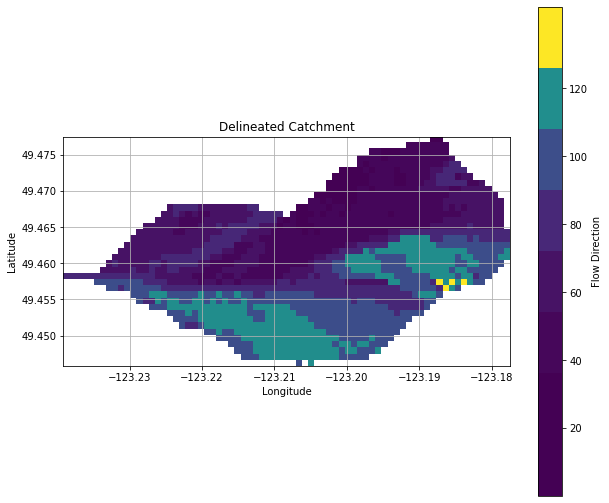

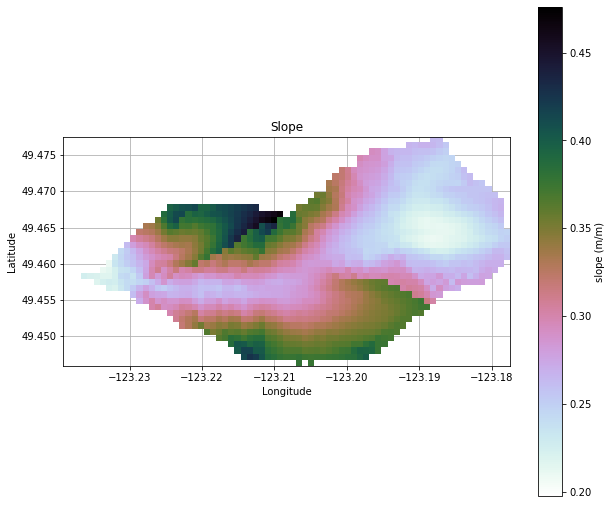

In [13]:
# coordinates of harvey creek : -123.222197,49.457422 
# coordinates of magnesia creek: -123.23388889,49.47396389

#note that functions can also be used separately

main()